Copy rights @Cheng Tang chengtang48@gmail.com

## Plan for numerical simulations

- low-rank data generation: high dimensional, from a subset of coordinates (these are eigenvectors)
- krasulina implementation (done)
- TODO:
    - investigate robustness of the algorithm to eigenvalue perturbations
    - investigate the effect of dimension and rank
    - investigate perturbed version (optional)
    - compare to Ohad Shamir's SVRG variant of Oja's method (optional)
- Simulation on real data (candidates: MNIST, CCAT?)


# pseodo-code for generalized krasulina
``` 
Input params: init_weights (W^0) (k by d), learning rate schedule (constant and inverse-time), max_iter (T)
While t <= T
 W^{t+1} = W^t + \eta^t W^t x (x - (W^t)^TW^tx)^T
 equivalent to: W^{t+1} = W^t + \eta^t (W^t x x^T - x^T(W^t)^TW^t)
 The step above is equivalent to one SGD update (given that W^t is row orthonormalized) on the objective:
 
 row orthonormalize W^{t+1}
```

In [1]:
from krasulina import KrasulinaPCA, get_random_orthogonal_initializer, get_eigenvecs
import numpy as np
import math

/Users/tcheng/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/Users/tcheng/.pyenv/versions/anaconda3-5.2.0/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [ ]:
#np.__config__.show()

In [ ]:
# data generators: data should be centered and dispersed around the subspace spanned by gt

def get_train_data(n_train, groundtruth=None, perturb=0.001):
    """
    gt: d-dimensional vec (non-increasing entries): 
    nonzero at coordinates corresponding to eigenvectors, and the value corresponds eigenvalue
    example: [1,1,0,0,0]
    return: np array train data
    """
    if not groundtruth:
        print("The data generator without groundtruth is not implemented!")
        return
    else:
        train_data = None
        d = len(groundtruth)
        for _ in range(n_train):
            x = np.zeros([1, d])
            for i in range(d):
                if groundtruth[i] > 0:
                    x[:, i] = np.random.normal(0, groundtruth[i]**0.5)
                elif perturb != 0:
                    x[:, i] = np.random.normal(0, perturb**0.5)
            if train_data is None:
                train_data = x
            else:
                train_data = np.concatenate((train_data, x), axis=0)  
            #print(train_data.shape)
    return train_data

In [ ]:
k=2
d=100
gt = [0] * d
for i in range(k):
    gt[i] = (k - i)**1
_init_weights = get_random_orthogonal_initializer(k, d)
n_train = 5000
eigenvecs = get_eigenvecs(gt)
train_data = get_train_data(n_train, groundtruth=gt)

In [ ]:
_init_weights

In [ ]:
T = 8
lr = (None, 0.01) 
#lr = (0.001, 10)
algo = KrasulinaPCA(_init_weights, train_data, groundtruth=eigenvecs, learning_rate=lr, max_iter=T * n_train)

In [ ]:
algo._train()

In [ ]:
print(algo._train_mse_log[0], algo._train_mse_log[-1])

In [ ]:
print(algo._groundtruth_eval_log[0], algo._groundtruth_eval_log[-1])

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
%matplotlib inline

In [ ]:
iterations = range(T)
#log_iterations = [math.log(t+1) for t in iterations]
log_error = [math.log(y) for y in algo._groundtruth_eval_log]

In [ ]:
epoch = 0
gt_eval_epoch_wise = list()
epoch_iters = list()
for t, e in enumerate(algo._groundtruth_eval_log):
    if t % n_train == 0:
        epoch += 1
        gt_eval_epoch_wise.append(e)
        epoch_iters.append(epoch)
    

In [ ]:
#plt.plot(iterations, log_error)
plt.plot(range(1+T), log_error)

In [ ]:
## train all variations
count = 1
n_train = 5000
algo_meta_dict = {}
for k in [1, 10]:
    for d in [10, 100, 500]:
        algo_list = []
        for eta in [(None, 0.0001/k), (0.001/k, 10)]:
            gt = [0] * d
            for i in range(k):
                gt[i] = (k-i) 
            _init_weights = get_random_orthogonal_initializer(k, d)
            print(f"Runing the {count}-th experiment")
            count += 1
            eigenvecs = get_eigenvecs(gt)
            train_data = get_train_data(n_train, groundtruth=gt)
            T = 8*n_train
            algo_list.append(KrasulinaPCA(_init_weights, train_data, groundtruth=eigenvecs, learning_rate=eta, max_iter=T))
            algo_list[-1]._train()
            print("Initial and final loss")
            print(algo_list[-1]._groundtruth_eval_log[0], algo_list[-1]._groundtruth_eval_log[-1])
        key = (k, d)
        algo_meta_dict[key] = algo_list
            

In [ ]:
algo_meta_dict.keys()

In [ ]:
import json

In [9]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
%matplotlib inline

In [ ]:
for k, d in algo_meta_dict.keys():
    for idx in [0, 1]:
        algo_meta_dict[(k, d)][idx]._groundtruth_eval_log

In [ ]:
## Plot on all
label_list = [r"$\eta=10^{-4}/k$", r"$\eta^t = \frac{10^{-3}}{k(t+10)}$"]

def get_log(k, d, idx, algo_dict):
    return algo_dict[(k, d)][idx]._groundtruth_eval_log


def plotting(k, d):
    fig=plt.figure()
    for idx in [0, 1]:
        log = get_log(k, d, idx, algo_meta_dict)
        epoch = 0
        gt_eval_epoch_wise = list()
        epoch_iters = list()
        for t, e in enumerate(log):
            if t % n_train == 0:
                epoch += 1
                gt_eval_epoch_wise.append(e)
                epoch_iters.append(epoch)
        #
        #log_epoch_iters = [math.log(t_e) for t_e in epoch_iters]
        log_gt_eval_epoch_wise = [math.log(e) if e > 0 else math.log(e+1) for e in gt_eval_epoch_wise]
        if idx == 1:
            #lr_params = (0.001/k, 10)
            #lr = r"$\frac{0.001}{k(t+10)}$" 
            plt.plot(epoch_iters, log_gt_eval_epoch_wise, '--', label=label_list[idx])
        else:
            #lr = r"\frac{0.0001}{k}"
            plt.plot(epoch_iters, log_gt_eval_epoch_wise, label=label_list[idx])
    plt.legend()
    #plt.title(f"k={k}, d={d}")
    plt.xlabel('epochs')
    plt.ylabel(r'log $\Delta^t$')
    fig.savefig(f"k-{k}-d-{d}.png")

for k, d in algo_meta_dict.keys():
    plotting(k,d)
    


In [ ]:
!zip figs.zip pre/*

In [ ]:
iterations = range(T)
log_iterations = [math.log(t+1) for t in iterations]
log_error = [math.log(y) if y > 0 else 0 for y in algo._groundtruth_eval_log]
#const = 100
#theo = [-t + const for t in iterations]

In [ ]:
plt.plot(iterations, log_error)
#plt.plot(iterations, theo)
#plt.plot(log_iterations, log_error)
#plt.plot(iterations, algo._groundtruth_eval_log)
#plt.plot(iterations, algo._train_mse_log)

In [ ]:
log_epoch_iters = [math.log(t_e) for t_e in epoch_iters]
log_gt_eval_epoch_wise = [math.log(e) for e in gt_eval_epoch_wise]
plt.plot(epoch_iters, log_gt_eval_epoch_wise)

In [ ]:
test_arr = [1,2,3]
#print(test_arr[:0])
if test_arr[:1]:
    print("not null")

In [ ]:
x = list(range(1000))
y = [1/float(t+1) for t in x]
y1 = [2**(-t) for t in x]
log_y = [math.log(e) for e in y]
log_y1 = [math.log(e) for e in y1]
plt.plot(x, log_y1)

### MNIST

In [ ]:
#!pip install python-mnist

In [ ]:
#!git clone https://github.com/sorki/python-mnist

In [ ]:
#!brew install wget

In [ ]:
# %%bash
# cd python-mnist
# ./get_data.sh

In [2]:
from mnist import MNIST
from sklearn.decomposition import PCA

In [3]:
mndata = MNIST('python-mnist/data')
images, labels = mndata.load_training()

In [4]:
import numpy as np

#images_array = np.array([np.array(data_pt) for data_pt in images[:5000]])
images_array = np.array([np.array(data_pt) for data_pt in images])
n_samples, n_features = images_array.shape
#images_array -= images_array.mean(axis=1).reshape(n_samples, -1)
print(n_samples, n_features)

60000 784


In [5]:
images_centered = images_array - images_array.mean(axis=0)

In [14]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=0.8, svd_solver='full')
#pca = decomposition.PCA(svd_solver='full')

In [15]:
pca.fit(images_centered)

pca.n_components_

44

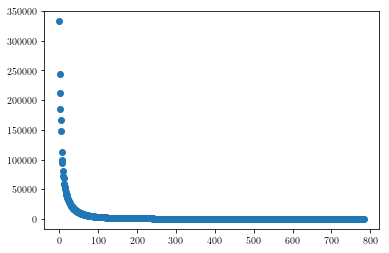

In [13]:
plt.plot(list(range(pca.n_components_)), pca.explained_variance_, 'o')

In [16]:
print(pca.explained_variance_[0], pca.explained_variance_[-1])

332724.66744656884 13652.82314029589


In [29]:
from vr_pca import VRPCA, get_default_learning_rate

k = 44
d = 784
_init_weights = get_random_orthogonal_initializer(k, d)

n_train = len(images_centered)
T = 1
lr = get_default_learning_rate(images_centered)
#lr = 0.01
#lr = 0.0001
#lr = (0.001, 10)
#vr_algo = VRPCA(_init_weights, images_centered, pca.components_, lr, n_train, T)
lr = 1e-08 
vr_algo = VRPCA(_init_weights, images_centered, pca.components_, lr, n_train, 
                T, log_freq=T*int(n_train/10.0))

In [30]:
vr_algo._train()

The loss at the 1-th epoch 0-th iteration is 41.543973225223255
The loss at the 1-th epoch 6000-th iteration is 18.408071836183638
The loss at the 1-th epoch 12000-th iteration is 10.05261038944657
The loss at the 1-th epoch 18000-th iteration is 6.072479818732089
The loss at the 1-th epoch 24000-th iteration is 4.221274078477826
The loss at the 1-th epoch 30000-th iteration is 3.2614733971120917
The loss at the 1-th epoch 36000-th iteration is 2.6630839935835366
The loss at the 1-th epoch 42000-th iteration is 2.283604285533433
The loss at the 1-th epoch 48000-th iteration is 1.961698280812204
The loss at the 1-th epoch 54000-th iteration is 1.720449979572432
The loss at the 3-th epoch is 1.720449979572432


In [ ]:
vr_algo.final_weights_.shape

In [26]:
##
k = 44
d = 784
_init_weights = get_random_orthogonal_initializer(k, d)
#_init_weights = vr_algo.final_weights_.T

T = 1*n_samples
log_freq = int(T / 10.0)
lr = (None, 1e-08) 
#lr = (1e-06, 100)
algo = KrasulinaPCA(_init_weights, images_centered, 
                    groundtruth=pca.components_, 
                    learning_rate=lr, max_iter=T, log_freq=log_freq)

In [27]:
algo._train()

The initial mse: 194143044741.09967
The initial loss: 41.52283759840593
The loss at the 0-th epoch 6000-th iteration is 18.765658249019655
The loss at the 0-th epoch 12000-th iteration is 9.730340936735413
The loss at the 0-th epoch 18000-th iteration is 5.224107291578832
The loss at the 0-th epoch 24000-th iteration is 3.2962233318793834
The loss at the 0-th epoch 30000-th iteration is 2.5130736976035277
The loss at the 0-th epoch 36000-th iteration is 2.133305714223872
The loss at the 0-th epoch 42000-th iteration is 1.929727727180559
The loss at the 0-th epoch 48000-th iteration is 1.7698258907028022
The loss at the 0-th epoch 54000-th iteration is 1.675907832588953
Finished training 1-th epoch with total 60000 iterations
The current learning rate is 1e-08
The loss at the 1-th epoch 60000-th iteration is 1.6435287072880365


In [ ]:
from krasulina import eval_mse_loss
#eval_mse_loss(images_centered, algo.final_weights_)
eval_mse_loss(images_centered, pca.components_)

In [ ]:
print(algo._train_mse_log[0], algo._train_mse_log[-1])
print(algo._groundtruth_eval_log[0], algo._groundtruth_eval_log[-1])

In [ ]:
epoch = 0
gt_eval_epoch_wise = list()
epoch_iters = list()
for t, e in enumerate(algo._groundtruth_eval_log):
    if t % n_train == 0:
        epoch += 1
        gt_eval_epoch_wise.append(e)
        epoch_iters.append(epoch)

In [ ]:
#iterations = range(11)
#log_iterations = [math.log(t+1) for t in iterations]
#log_error = [math.log(y) if y > 0 else 0 for y in algo._groundtruth_eval_log[:20]]
plt.plot(range(20), algo._groundtruth_eval_log[:20])
#plt.plot(range(20), log_error)
plt.loglog()
#plt.plot(log_iterations, log_error)

In [ ]:
algo._groundtruth_eval_log

### Faces low-rank dataset

In [ ]:
from numpy.random import RandomState
from sklearn.datasets import fetch_olivetti_faces

rng = RandomState(0)

# Load faces data
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# local centering
faces -= faces.mean(axis=1).reshape(n_samples, -1)

# global centering
faces_centered = faces - faces.mean(axis=0)

print("Dataset consists of %d faces" % n_samples)

In [ ]:
len(faces_centered)
faces_centered.mean(axis=0)

In [ ]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=0.8, svd_solver='full')

In [ ]:
pca.fit(faces_centered)

In [ ]:
pca.n_components_

In [ ]:
pca.components_.shape

In [ ]:
plt.plot(list(range(pca.n_components_)), pca.explained_variance_, 'o')

In [ ]:
print(pca.explained_variance_[0], pca.explained_variance_[-1])

In [ ]:
from vr_pca import VRPCA, get_default_learning_rate

k = 37
d = 4096
_init_weights = get_random_orthogonal_initializer(k, d)

n_train = len(faces_centered)
T = 5
lr = get_default_learning_rate(faces_centered)
#lr = 0.01
#lr = 0.0001
#lr = (0.001, 10)
vr_algo = VRPCA(_init_weights, faces_centered, pca.components_, lr, n_train, T)

In [ ]:
vr_algo._train()

In [ ]:
##
k = 37
d = 4096
_init_weights = get_random_orthogonal_initializer(k, d)

n_train = len(faces_centered)
T = 10*n_train
lr = (None, 0.005) 
#lr = (0.001, 10)
algo = KrasulinaPCA(_init_weights, faces_centered, groundtruth=pca.components_, 
                    learning_rate=lr, mini_batch_size=1, max_iter=T)

In [ ]:
algo._train()

In [ ]:
#eval_mse_loss(faces_centered, pca.components_)
eval_mse_loss(faces_centered, algo.final_weights_)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True
%matplotlib inline

In [ ]:
eps = 1e-6
log_error = [math.log(y) if y > 0 else math.log(y+eps) for y in algo._groundtruth_eval_log]
plt.plot(range(11), log_error)

In [ ]:
algo._groundtruth_eval_log[-1]

## 20 Newsgroup

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import PCA

newsgroups_train = fetch_20newsgroups(subset='train', 
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=['comp.graphics', 'rec.autos', 'sci.crypt', 'talk.politics.mideast'])

In [2]:
print(newsgroups_train.target_names)

['comp.graphics', 'rec.autos', 'sci.crypt', 'talk.politics.mideast']


In [3]:
print(newsgroups_train.filenames[0])
print(newsgroups_train.filenames.shape)
print(newsgroups_train.target.shape)

/Users/tcheng/scikit_learn_data/20news_home/20news-bydate-train/sci.crypt/15504
(2337,)
(2337,)


In [ ]:
# categories = ['comp.os.ms-windows.misc', 'rec.sport.baseball', 
#               'talk.politics.mideast', 'rec.motorcycles', 'soc.religion.christian']
# newsgroups_train_subcat = fetch_20newsgroups(subset='train', categories=categories)

In [ ]:
newsgroups_train.data[0]

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(lowercase=True, max_features=3000)

In [13]:
data_vecs = vectorizer.fit_transform(newsgroups_train.data).todense()

In [14]:
n_samples, n_dim = data.shape
print(n_samples, n_dim)

2337 3000


In [12]:
# local centering
#data_vecs -= data_vecs.mean(axis=1).reshape(n_samples, -1)

# global centering
#data_vecs_centered = data_vecs - data_vecs.mean(axis=0)
#data_vecs_centered

matrix([[-0.00226909, -0.00313657, -0.00092669, ..., -0.00058023,
         -0.00119019, -0.00077986],
        [-0.00226909, -0.00313657, -0.00092669, ..., -0.00058023,
         -0.00119019, -0.00077986],
        [-0.00226909, -0.00313657, -0.00092669, ..., -0.00058023,
         -0.00119019, -0.00077986],
        ...,
        [-0.00226909, -0.00313657, -0.00092669, ..., -0.00058023,
         -0.00119019, -0.00077986],
        [-0.00226909, -0.00313657, -0.00092669, ..., -0.00058023,
         -0.00119019, -0.00077986],
        [-0.00226909, -0.00313657, -0.00092669, ..., -0.00058023,
         -0.00119019, -0.00077986]])

In [15]:
pca2 = PCA(n_components=0.8, svd_solver='full')
#pca2.fit(data_vecs_centered)
pca2.fit(data_vecs)

PCA(copy=True, iterated_power='auto', n_components=0.8, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [16]:
pca2.n_components_

706

In [ ]:
plt.plot(list(range(pca2.n_components_)), pca2.explained_variance_, 'ro')

In [ ]:
pca2.explained_variance_[0]

In [ ]:
##
k = 250
d = 6000
_init_weights = get_random_orthogonal_initializer(k, d)

n_train = len(data_vecs_centered)
#T = int(10*n_train*0.005)
T = int(n_train * 0.5)
log_freq = int(T/20.0)
print(f"Total number of iterations: {T}; log frequency: {log_freq}")
#lr = (None, get_default_learning_rate(faces_centered))
#print(get_default_learning_rate(data_vecs_centered))
#lr = (None, 0.005) 
lr = (None, 100)
#lr = (0.001, 10)
algo = KrasulinaPCA(_init_weights, data_vecs_centered, groundtruth=pca2.components_, 
                    learning_rate=lr, mini_batch_size=1, max_iter=T, log_freq=log_freq)

In [ ]:
algo._train()

In [ ]:
len(algo._groundtruth_eval_log)

In [ ]:
eps = 1e-6
log_error = [math.log(y) if y > 0 else math.log(y+eps) for y in algo._groundtruth_eval_log]
#plt.plot(range(6), log_error)
plt.plot(range(6), algo._groundtruth_eval_log, 'o-')

In [ ]:
from vr_pca import VRPCA, get_default_learning_rate

k = 250
d = 6000
_init_weights = get_random_orthogonal_initializer(k, d)

n_train = len(data_vecs_centered)
T = 1
#lr = get_default_learning_rate(data_vecs_centered)
lr = 20
#lr = 0.0001
#lr = (0.001, 10)
vr_algo = VRPCA(_init_weights, data_vecs_centered, pca2.components_, lr, n_train, T)

In [ ]:
vr_algo._train() # runs more than 8 hours and still no result !

## Vgg Dataset

script adapted from <https://github.com/cmusatyalab/openface/blob/master/data/vgg/download-and-align.py>

In [ ]:
!rm -r aligned

In [ ]:
!python preprocess.py

In [24]:
import numpy as np
import os
import cv2

def load_vgg(path_to_images):
    tot_n_images = 0
    for (dirpath, _, _) in os.walk(path_to_images):
        tot_n_images += len(os.listdir(dirpath))
    print(f"Total number of aligned images is {tot_n_images}")
    img_data = []
    for (dirname, _, filenames) in os.walk(path_to_images):
        for im in filenames:
            im_path = os.path.join(dirname, im)
            grey_img = cv2.imread(im_path, 0)
            img_data.append(grey_img.flatten())
    dataset = np.stack(img_data, axis=0)
    return dataset

In [25]:
vgg_data = load_vgg('aligned')

Total number of aligned images is 10826


In [26]:
vgg_data.shape

(10806, 2304)

In [27]:
n_samples, n_features = vgg_data.shape

# local centering
#vgg_data -= vgg_data.mean(axis=1).reshape(n_samples, -1)
# global centering
vgg_centered = vgg_data - vgg_data.mean(axis=0)

In [32]:
from sklearn import decomposition

#pca = decomposition.PCA(n_components=0.8, svd_solver='full')
pca = decomposition.PCA(svd_solver='full')

In [33]:
pca.fit(vgg_centered)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='full', tol=0.0, whiten=False)

In [34]:
pca.n_components_

2304

In [40]:
import matplotlib.pyplot as plt
import matplotlib
#matplotlib.rcParams['text.usetex'] = True
#matplotlib.rcParams['text.latex.unicode'] = True
%matplotlib inline

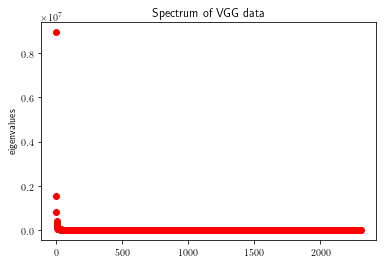

In [52]:
plt.plot(list(range(pca.n_components_)), pca.explained_variance_, 'ro')
plt.ylabel('eigenvalues')
plt.title('Spectrum of VGG data')
plt.savefig('vgg_spectrum.png')

Text(0.5,1,'Top 50 eigenvalues of Vgg data')

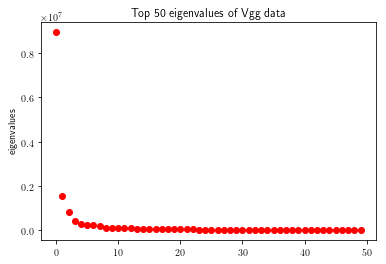

In [39]:
plt.plot(list(range(50)), pca.explained_variance_[:50], 'ro')
plt.ylabel('eigenvalues')
plt.title('Top 50 eigenvalues of Vgg data')

In [ ]:
print(pca.explained_variance_[0], pca.explained_variance_[-1])

In [ ]:
0.001/10001

In [ ]:
##
k = 6
d = 2304
_init_weights = get_random_orthogonal_initializer(k, d)

n_train = len(vgg_centered)
mb_size = 1
T = int(n_train / float(mb_size))

#lr = (None, 1e-07) 
lr = (1e-07, 100)
log_freq = int(T / 10.0)
algo = KrasulinaPCA(_init_weights, vgg_centered, groundtruth=pca.components_, 
                    learning_rate=lr, mini_batch_size=1, max_iter=T, log_freq=log_freq)

In [ ]:
algo._train()

In [ ]:
len(algo._groundtruth_eval_log)

In [ ]:
log_error = [math.log(x) for x in algo._groundtruth_eval_log] 

In [ ]:
#plt.plot(range(len(algo._groundtruth_eval_log)), algo._groundtruth_eval_log)
#plt.loglog()
plt.plot(range(len(algo._groundtruth_eval_log)), log_error)
# check MSE
# check 1/t learning rate 
# (we can slightly change the narrative if this works)

In [ ]:
from vr_pca import VRPCA, get_default_learning_rate

k = 6
d = 2304
_init_weights = get_random_orthogonal_initializer(k, d)

n_train = len(vgg_centered)
T = 1
#lr = get_default_learning_rate(vgg_centered)
lr = 1e-07
#lr = 0.0001
#lr = (0.001, 10)
vr_algo = VRPCA(_init_weights, vgg_centered, pca.components_, lr, n_train, T)

In [ ]:
vr_algo._train()

In [ ]:
from oja import Oja

k = 6
d = 2304
_init_weights = get_random_orthogonal_initializer(k, d)

n_train = len(vgg_centered)
mb_size = 1
T = int(n_train / float(mb_size))

#lr = (None, 1e-07) 
lr = (1e-07, 100)
log_freq = int(T / 10.0)
oja_algo = Oja(_init_weights, vgg_centered, groundtruth=pca.components_, 
                    learning_rate=lr, mini_batch_size=1, max_iter=T, log_freq=log_freq)

In [ ]:
oja_algo._train()

In [ ]:
import json

In [ ]:
json.loads('{"in0": [1.2], "in1": [10.3]}', parse_int)

In [ ]:
adict = {1:[11,2], 0:[1]}

In [ ]:
for k, v in adict.items():
    print(k)
    print(v)

In [ ]:
adict.clear()

In [ ]:
adict

In [ ]:
adict.clear()